In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from meus.printer import *
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

data = str(datetime.now().year)+'-'+str(datetime.now().month)+'-'+str(datetime.now().day)
data

'2020-4-24'

In [2]:
os.chdir('E:\\OneDrive\\Programação\\python\\covid\\data\\results')
directory = os.listdir('..')
printLis(directory)

-------------
-=< Lista >=-
-------------
0 -> .ipynb_checkpoints
1 -> .~lock.covid19_municipios.csv#
2 -> artigo
3 -> caso_full.csv
4 -> cities.csv
5 -> covid19_municipios.csv
6 -> COVID19_REGIOES BR.csv
7 -> Dados_demográficos_municípios.xlsx
8 -> Dados_demográficos_municípios_new.xlsx
9 -> Datalab_COVID.pptx
10 -> figures
11 -> idade.xlsx
12 -> obito_cartorio.csv
13 -> População residente municipal x população faixa etária.csv
14 -> População residente por estado - 2015.csv
15 -> População residente x sexo.csv
16 -> results


In [3]:
date = 3
df_cov =  pd.read_csv('..\\'+directory[date])
df_cov.tail()

,city,city_ibge_code,date,estimated_population_2019,is_repeated,is_last,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_date,last_available_death_rate,last_available_deaths,place_type,state,new_confirmed,new_deaths
26577,NaN,43.0,2020-04-22,11377239.0,False,True,970,8.52579,2020-04-22,0.0289,28,state,RS,52,1
26578,NaN,42.0,2020-04-22,7164788.0,False,True,1115,15.56222,2020-04-22,0.0350,39,state,SC,24,2
26579,NaN,28.0,2020-04-22,2298696.0,False,True,118,5.13335,2020-04-22,0.0593,7,state,SE,1,0
26580,NaN,35.0,2020-04-22,45919049.0,False,True,15914,34.65664,2020-04-22,0.0713,1134,state,SP,529,41
26581,NaN,17.0,2020-04-22,1572866.0,False,True,37,2.35239,2020-04-22,0.0541,2,state,TO,1,0


In [4]:
# df_cov = df_cov[(df_cov['last_available_date'] == '2020-04-10') & (df_cov['place_type'] == 'city')][[
#     "estimated_population_2019",
#     "last_available_confirmed",
#     "last_available_deaths",
#     "last_available_confirmed_per_100k_inhabitants",
#     "last_available_death_rate",
#     "city",
#     "last_available_date"
# ]]
# df_cov = df_cov.rename(columns={
#     "estimated_population_2019": "Population",
#     "last_available_confirmed": "Confirmed",
#     "last_available_deaths": "Deaths",
#     "last_available_confirmed_per_100k_inhabitants": "Confirmed/100k",
#     "last_available_death_rate": "Death Rate",
#     "city": "City",
#     "last_available_date": "Date"
# })
# df_cov.index.name = 'Date'
# df_cov.head()

In [5]:
df_cov.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26582 entries, 0 to 26581
Data columns (total 15 columns):
city                                             25477 non-null object
city_ibge_code                                   26151 non-null float64
date                                             26582 non-null object
estimated_population_2019                        26151 non-null float64
is_repeated                                      26582 non-null bool
is_last                                          26582 non-null bool
last_available_confirmed                         26582 non-null int64
last_available_confirmed_per_100k_inhabitants    25749 non-null float64
last_available_date                              26582 non-null object
last_available_death_rate                        6174 non-null float64
last_available_deaths                            26582 non-null int64
place_type                                       26582 non-null object
state                                     

In [6]:
teste = 'date'
df_cov = df_cov[['last_available_confirmed', 'last_available_deaths', 'last_available_confirmed_per_100k_inhabitants', teste]]
df_cov[teste] = pd.to_datetime(df_cov[teste])
group = df_cov.groupby(teste)
df = pd.DataFrame()
df['Confirmed'] = group.sum()['last_available_confirmed']
df['Deaths'] = group.sum()['last_available_deaths']
df['Confirmed/100k'] = group.sum()['last_available_confirmed_per_100k_inhabitants']
df.index.name = 'Date'
df.head()

,Confirmed,Deaths,Confirmed/100k
Date,,,
2020-02-25,2,0,0.01034
2020-02-26,2,0,0.01034
2020-02-27,2,0,0.01034
2020-02-28,4,0,0.02068
2020-02-29,4,0,0.02068


In [7]:
df.tail()

,Confirmed,Deaths,Confirmed/100k
Date,,,
2020-04-18,74348,4750,18378.87578
2020-04-19,78212,4981,19895.41860
2020-04-20,81859,5196,21028.12907
2020-04-21,87289,5542,22462.29763
2020-04-22,91859,5834,24121.67284


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 58 entries, 2020-02-25 to 2020-04-22
Data columns (total 3 columns):
Confirmed         58 non-null int64
Deaths            58 non-null int64
Confirmed/100k    58 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.8 KB


In [9]:
g = 1
campo = 'Confirmed'
print_campo = 's'
figsize=(30, 5)
first = '2020-' + str(df.tail(1).index.month[0] - 1) + '-' + str(df.tail(1).index.day[0])
last = '2020-' + str(df.tail(1).index.month[0] + 1) + '-' + str(df.tail(1).index.day[0])
start = '2020-' + str(df.head(1).index.month[0]) + '-' + str(df.head(1).index.day[0])
end = '2020-' + str(df.tail(1).index.month[0]) + '-' + str(df.tail(1).index.day[0])
try:
    os.mkdir('ts')
    print('Directory created')
except FileExistsError:
    print('Directory already exists')

Directory created


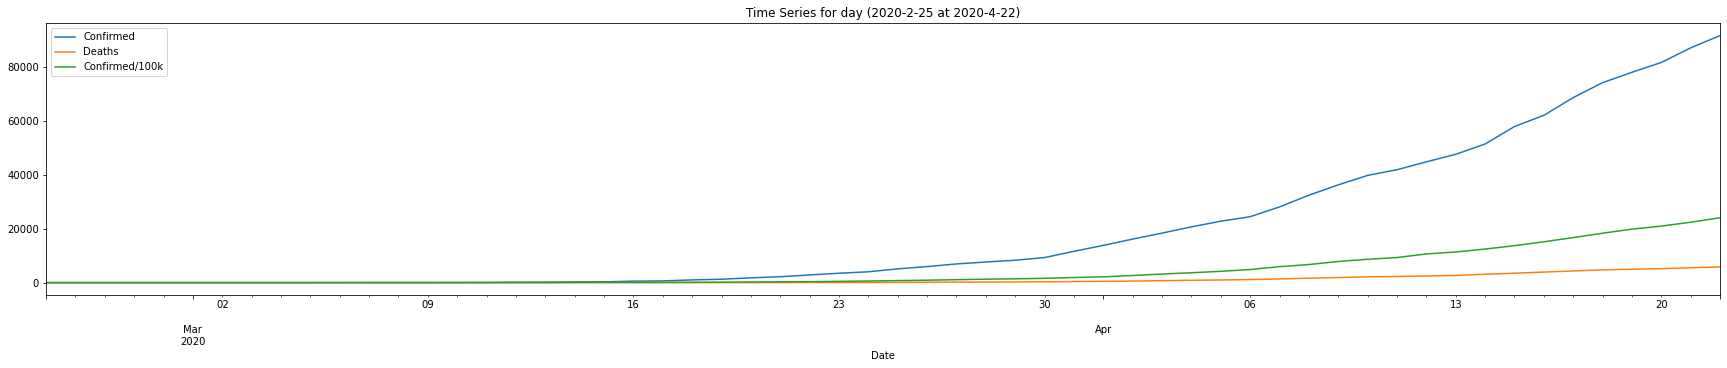

In [10]:
df.plot(figsize=figsize)
plt.title('Time Series for day ('+str(start)+' at '+str(end)+')')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

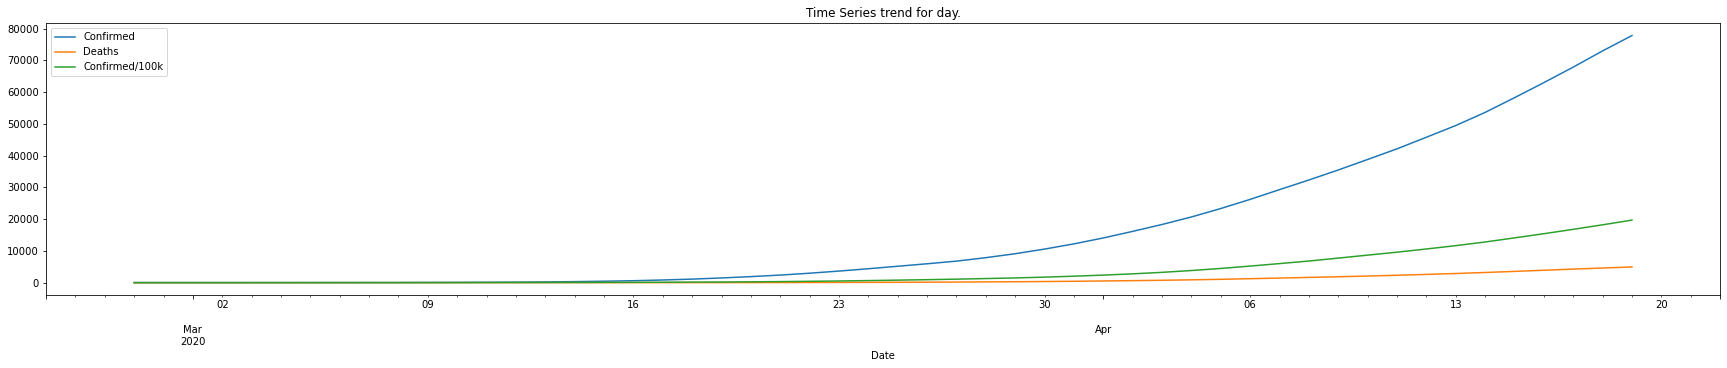

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
dec = seasonal_decompose(df[campo])
dec.trend.plot(figsize=figsize, ax=ax)

campo1 = 'Deaths'
dec = seasonal_decompose(df[campo1])
dec.trend.plot(figsize=figsize, ax=ax)

campo2 = 'Confirmed/100k'
dec = seasonal_decompose(df[campo2])
dec.trend.plot(figsize=figsize, ax=ax)

plt.legend([campo, campo1, campo2])
plt.title('Time Series trend for day.')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

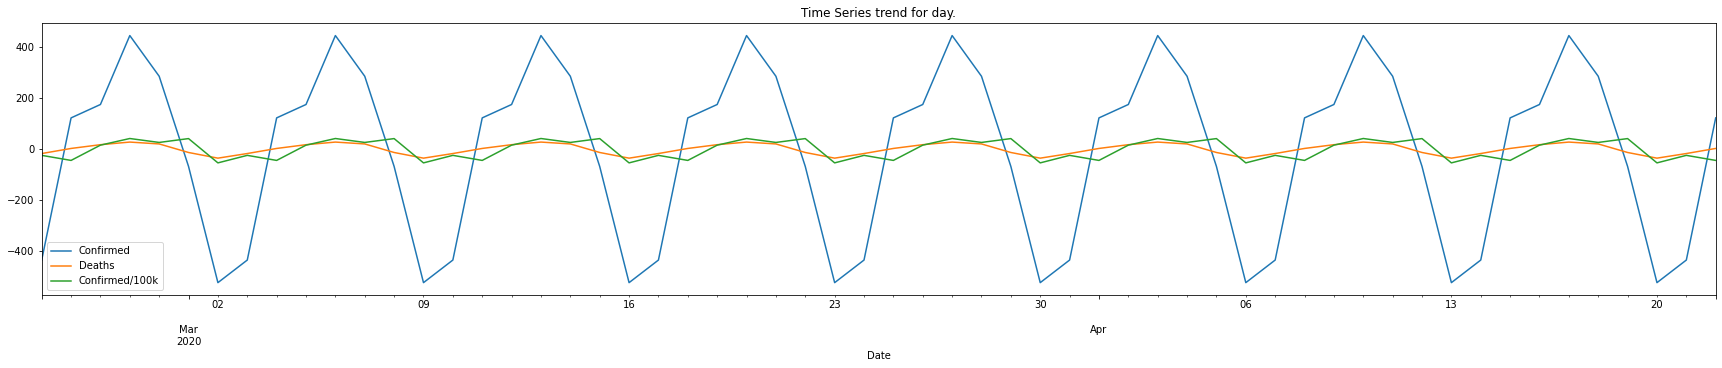

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
dec = seasonal_decompose(df[campo])
dec.seasonal.plot(figsize=figsize, ax=ax)

campo1 = 'Deaths'
dec = seasonal_decompose(df[campo1])
dec.seasonal.plot(figsize=figsize, ax=ax)

campo2 = 'Confirmed/100k'
dec = seasonal_decompose(df[campo2])
dec.seasonal.plot(figsize=figsize, ax=ax)

plt.legend([campo, campo1, campo2])
plt.title('Time Series trend for day.')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

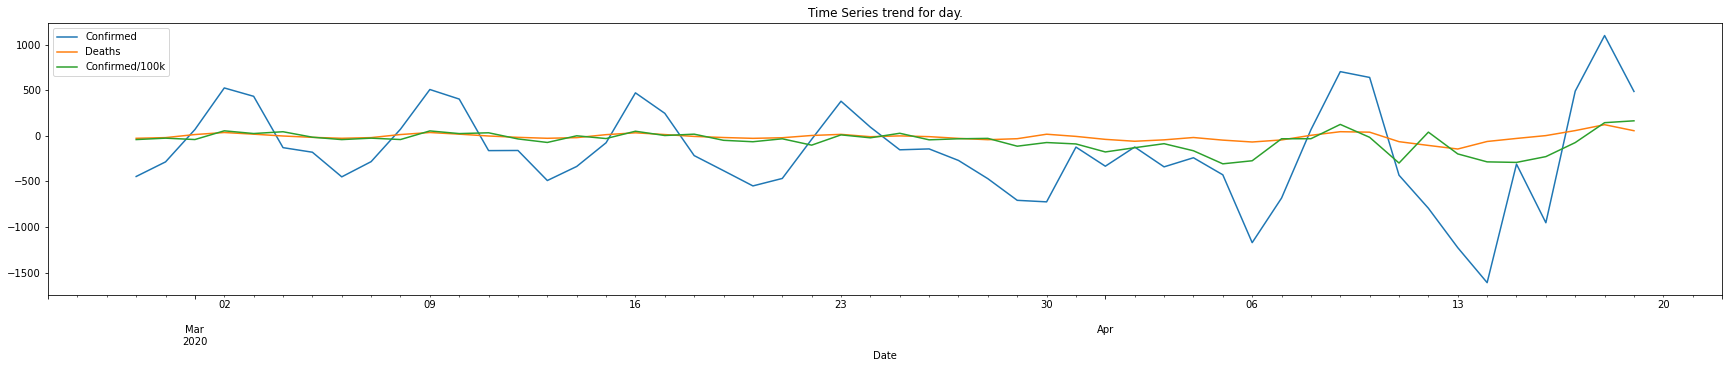

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
dec = seasonal_decompose(df[campo])
dec.resid.plot(figsize=figsize, ax=ax)

campo1 = 'Deaths'
dec = seasonal_decompose(df[campo1])
dec.resid.plot(figsize=figsize, ax=ax)

campo2 = 'Confirmed/100k'
dec = seasonal_decompose(df[campo2])
dec.resid.plot(figsize=figsize, ax=ax)

plt.legend([campo, campo1, campo2])
plt.title('Time Series trend for day.')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [14]:
for p in range(3):
    for q in range(3):
        for d in range(3):
            test = (p, q, d)
            modelo = ARIMA(df[campo], order=test, freq='D')
            try:
                results = modelo.fit()
                print(f'({p}, {q}, {d})')
                print(results.summary())
                print()
            except: 
                print('Não')

(0, 0, 0)
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                   58
Model:                     ARMA(0, 0)   Log Likelihood                -673.365
Method:                           css   S.D. of innovations          26656.916
Date:                Fri, 24 Apr 2020   AIC                           1350.730
Time:                        16:59:51   BIC                           1354.851
Sample:                    02-25-2020   HQIC                          1352.335
                         - 04-22-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.925e+04   3500.224      5.499      0.000    1.24e+04    2.61e+04

(0, 0, 1)
                              ARMA Model Results                              
Dep. Variable:              Con

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(0, 0, 2)
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                   58
Model:                     ARMA(0, 2)   Log Likelihood                -603.866
Method:                       css-mle   S.D. of innovations           7135.188
Date:                Fri, 24 Apr 2020   AIC                           1215.733
Time:                        16:59:51   BIC                           1223.975
Sample:                    02-25-2020   HQIC                          1218.943
                         - 04-22-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.004e+04   3686.142      5.436      0.000    1.28e+04    2.73e+04
ma.L1.Confirmed     2.0000      0.072     27.809      0.000       1.859       2.141
ma.L2.Confirmed     1.

(1, 1, 0)
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   57
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -462.971
Method:                       css-mle   S.D. of innovations            802.528
Date:                Fri, 24 Apr 2020   AIC                            931.942
Time:                        16:59:51   BIC                            938.071
Sample:                    02-26-2020   HQIC                           934.324
                         - 04-22-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1787.8916   1033.811      1.729      0.084    -238.340    3814.123
ar.L1.D.Confirmed     0.9116      0.053     17.194      0.000       0.808       1.016
              

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:220: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:689: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:690: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInve


                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   57
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -460.079
Method:                       css-mle   S.D. of innovations            759.913
Date:                Fri, 24 Apr 2020   AIC                            928.157
Time:                        16:59:52   BIC                            936.330
Sample:                    02-26-2020   HQIC                           931.333
                         - 04-22-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2041.4422   1615.755      1.263      0.206   -1125.380    5208.265
ar.L1.D.Confirmed     0.9754      0.029     33.687      0.000       0.919       1.032
ma.L1.D.Confirmed    -0

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\gfsil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\gfsil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\gfsil\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(1, 2, 1)
                             ARIMA Model Results                              
Dep. Variable:           D2.Confirmed   No. Observations:                   56
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -448.435
Method:                       css-mle   S.D. of innovations            723.504
Date:                Fri, 24 Apr 2020   AIC                            904.871
Time:                        16:59:52   BIC                            912.972
Sample:                    02-27-2020   HQIC                           908.011
                         - 04-22-2020                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 92.2429     31.147      2.962      0.003      31.195     153.290
ar.L1.D2.Confirmed     0.3015      0.175      1.724      0.085      -0.041       0.644
ma.L1.D2.C

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1663: RuntimeWarning: invalid value encountered in double_scalars
  ('S.D. of innovations', ["%#5.3f" % self.sigma2 ** .5]),


(2, 0, 0)
                              ARMA Model Results                              
Dep. Variable:              Confirmed   No. Observations:                   58
Model:                     ARMA(2, 0)   Log Likelihood                -481.356
Method:                       css-mle   S.D. of innovations                nan
Date:                Fri, 24 Apr 2020   AIC                            970.712
Time:                        16:59:52   BIC                            978.954
Sample:                    02-25-2020   HQIC                           973.923
                         - 04-22-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.925e+04        nan        nan        nan         nan         nan
ar.L1.Confirmed     1.9744   2.09e-05   9.44e+04      0.000       1.974       1.974
ar.L2.Confirmed    -0.

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 1)
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   57
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -462.729
Method:                       css-mle   S.D. of innovations            757.212
Date:                Fri, 24 Apr 2020   AIC                            935.457
Time:                        16:59:52   BIC                            945.672
Sample:                    02-26-2020   HQIC                           939.427
                         - 04-22-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               3.74e+04        nan        nan        nan         nan         nan
ar.L1.D.Confirmed     1.2415      0.000   5391.414      0.000       1.241       1.242
ar.L2.D.Confir

C:\Users\gfsil\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


(2, 1, 2)
                             ARIMA Model Results                              
Dep. Variable:            D.Confirmed   No. Observations:                   57
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -462.932
Method:                       css-mle   S.D. of innovations            756.951
Date:                Fri, 24 Apr 2020   AIC                            937.864
Time:                        16:59:53   BIC                            950.122
Sample:                    02-26-2020   HQIC                           942.628
                         - 04-22-2020                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              4.636e+04        nan        nan        nan         nan         nan
ar.L1.D.Confirmed     1.3537   6.83e-05   1.98e+04      0.000       1.354       1.354
ar.L2.D.Confir

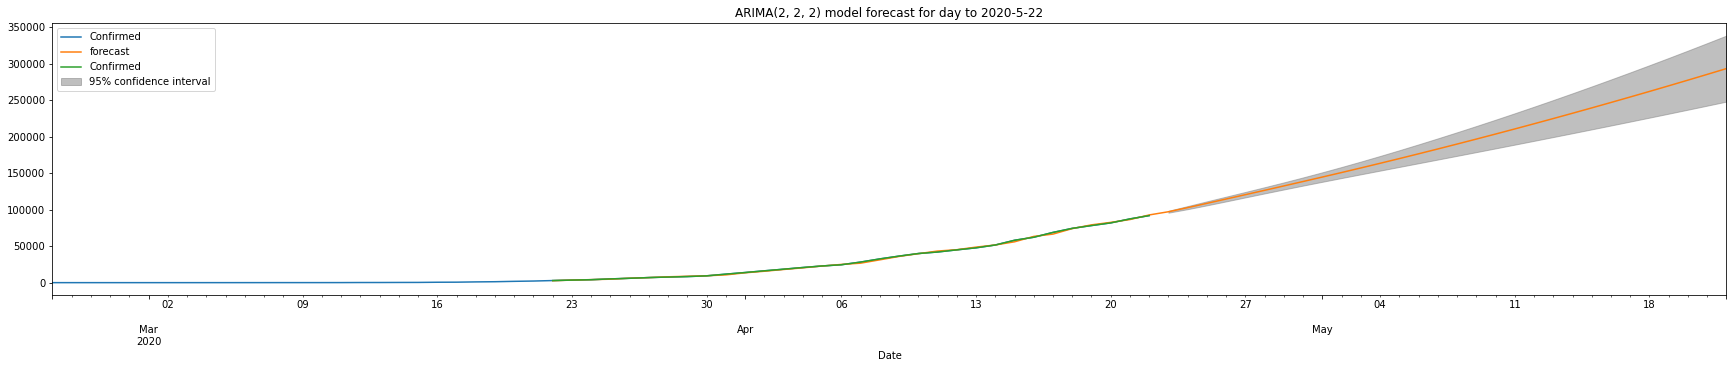

In [15]:
test = (2,2,2) #paramentros guardados em uma variável
modelo = ARIMA(df[campo], order=test, freq='D') #parametros para o modelo preditivo
results = modelo.fit() #ajuste de modelo
plt.figure(figsize=figsize) #plotando imagem
results.plot_predict(
   first, last,               #plotando a primeira e ultima data?
    ax = df[campo].plot(), #filtrando e usando apenas a coluna 'confirmed'
    plot_insample=True,
)
plt.title('ARIMA'+str(test)+' model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [16]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.Confirmed   No. Observations:                   56
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -444.623
Method:                       css-mle   S.D. of innovations            649.494
Date:                Fri, 24 Apr 2020   AIC                            901.247
Time:                        17:00:46   BIC                            913.399
Sample:                    02-27-2020   HQIC                           905.958
                         - 04-22-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 88.1343     34.870      2.527      0.011      19.790     156.479
ar.L1.D2.Confirmed     1.2429      0.123     10.114      0.000       1.002       1.484
ar.L2.D2.Confirmed    -0.4527      0.138     -3.285      0.001      -0.723      -0.183
ma.L1.D2.Confirmed    -1.9125      0.075    -25.475      0.000      -2.060      -1.765
ma.L2.D2.Confirmed     1.0000      0.075     13.392      0.000       0.854       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3727           -0.5698j            1.4862           -0.0626
AR.2            1.3727           +0.5698j            1.4862            0.0626
MA.1            0.9563           -0.2925j            1.0000           -0.0472
MA.2            0.9563           +0.2925j            1.0000            0.0472
-----------------------------------------------------------------------------
"""

In [17]:
pred = results.forecast(steps=30)
pred

(array([ 97126.23170264, 102785.68831897, 108635.47987553, 114562.76326004,
        120518.68681951, 126493.61945933, 132497.70653015, 138547.91739497,
        144660.74979999, 150849.02605583, 157121.21390885, 163482.03286806,
        169933.51523392, 176476.05032473, 183109.20197331, 189832.2518357 ,
        196644.50456371, 203545.4211332 , 210534.64639936, 217611.98298539,
        224777.3463553 , 232030.72079622, 239372.12504922, 246801.58952024,
        254319.14351554, 261924.80969384, 269618.60294969, 277400.53153725,
        285270.59897245, 293228.80588838]),
 array([  649.49352014,  1080.92767256,  1402.38511046,  1660.80735754,
         1902.75483868,  2166.1786529 ,  2479.86084485,  2862.30503214,
         3321.16191238,  3855.21674418,  4458.05785986,  5121.47115256,
         5837.58461922,  6599.82366681,  7403.1067107 ,  8243.67064127,
         9118.77307423, 10026.39829185, 10965.01825496, 11933.41947304,
        12930.58794244, 13955.63815227, 15007.77216837, 16086.25

In [21]:
import warnings
import itertools
warnings.filterwarnings("ignore")

In [24]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]
y = df[campo]
aic_list = list()
param_list = list()
param_s_list = list()
# for param in pdq:
param = test
for param_seasonal in seasonal_pdq:
    try:
        results = sm.tsa.statespace.SARIMAX(
                        y,
                        order=(2,2,2),
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False
        ).fit()
        print(f'ARIMA{param}x{param_seasonal} - AIC:{results.aic}')
        param_list.append(param)
        param_s_list.append(param_seasonal)
        aic_list.append(results.aic)
    except: 
        continue

ARIMA(2, 2, 2)x(0, 0, 0, 30) - AIC:860.962602455235
ARIMA(2, 2, 2)x(0, 0, 1, 30) - AIC:397.74644677994615
ARIMA(2, 2, 2)x(0, 0, 2, 30) - AIC:14.0
ARIMA(2, 2, 2)x(0, 1, 0, 30) - AIC:396.54332997762094
ARIMA(2, 2, 2)x(0, 1, 1, 30) - AIC:12.0
ARIMA(2, 2, 2)x(0, 1, 2, 30) - AIC:14.0
ARIMA(2, 2, 2)x(0, 2, 0, 30) - AIC:10.0
ARIMA(2, 2, 2)x(0, 2, 1, 30) - AIC:12.0
ARIMA(2, 2, 2)x(0, 2, 2, 30) - AIC:14.0
ARIMA(2, 2, 2)x(1, 0, 0, 30) - AIC:410.1494549332703
ARIMA(2, 2, 2)x(1, 0, 1, 30) - AIC:397.8460933327864
ARIMA(2, 2, 2)x(1, 0, 2, 30) - AIC:16.0
ARIMA(2, 2, 2)x(1, 1, 0, 30) - AIC:12.0
ARIMA(2, 2, 2)x(1, 1, 1, 30) - AIC:14.0
ARIMA(2, 2, 2)x(1, 1, 2, 30) - AIC:16.0
ARIMA(2, 2, 2)x(1, 2, 0, 30) - AIC:12.0
ARIMA(2, 2, 2)x(1, 2, 1, 30) - AIC:14.0
ARIMA(2, 2, 2)x(1, 2, 2, 30) - AIC:16.0
ARIMA(2, 2, 2)x(2, 0, 0, 30) - AIC:14.0
ARIMA(2, 2, 2)x(2, 0, 1, 30) - AIC:16.0
ARIMA(2, 2, 2)x(2, 0, 2, 30) - AIC:18.0
ARIMA(2, 2, 2)x(2, 1, 0, 30) - AIC:14.0
ARIMA(2, 2, 2)x(2, 1, 1, 30) - AIC:16.0
ARIMA(2, 2, 2)

In [25]:
best = aic_list.index(min(aic_list))
print(f'SARIMA{param_list[best]}x{param_s_list[best]} - AIC:{aic_list[best]}')

SARIMA(2, 2, 2)x(0, 2, 0, 30) - AIC:10.0


In [82]:
param_s_list_best=(1,0,1,30)
# param_s_list_best=param_s_list[best]
mod = sm.tsa.statespace.SARIMAX(
                                y,
                                order=test,
                                seasonal_order=param_s_list_best,
                                enforce_stationarity=False,
                                enforce_invertibility=False
)
print(f'SARIMA{param_list[best]}x{param_s_list_best} - AIC:{aic_list[best]}')
results = mod.fit()
results.summary()

SARIMA(2, 2, 2)x(1, 0, 1, 30) - AIC:10.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Confirmed   No. Observations:                   58
Model:             SARIMAX(2, 2, 2)x(1, 0, [1], 30)   Log Likelihood                -191.923
Date:                              Fri, 24 Apr 2020   AIC                            397.846
Time:                                      17:13:12   BIC                            405.795
Sample:                                  02-25-2020   HQIC                           399.845
                                       - 04-22-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1910      2.275      0.524      0.601      -3.268       5.650
ar.L2         -0.2869      2.108     -0.136      0.892      -4.418       3.844
ma.L1         -1.9664      4.908     -0.401      0.689     -11.587       7.654
ma.L2          0.9811      4.969      0.197      0.843      -8.758      10.720
ar.S.L30       2.9047      6.470      0.449      0.653      -9.776      15.585
ma.S.L30       0.9724      7.795      0.125      0.901     -14.306      16.251
sigma2      6.374e+05    1.6e-05   3.98e+10      0.000    6.37e+05    6.37e+05
===================================================================================
Ljung-Box (Q):                       18.67   Jarque-Bera (JB):                 0.15
Prob(Q):                              0.67   Prob(JB):                         0.93
Heteroskedasticity (H):               3.47   Skew:                             0.18
Prob(H) (two-sided):                  0.10   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.15e+27. Standard errors may be unstable.
"""

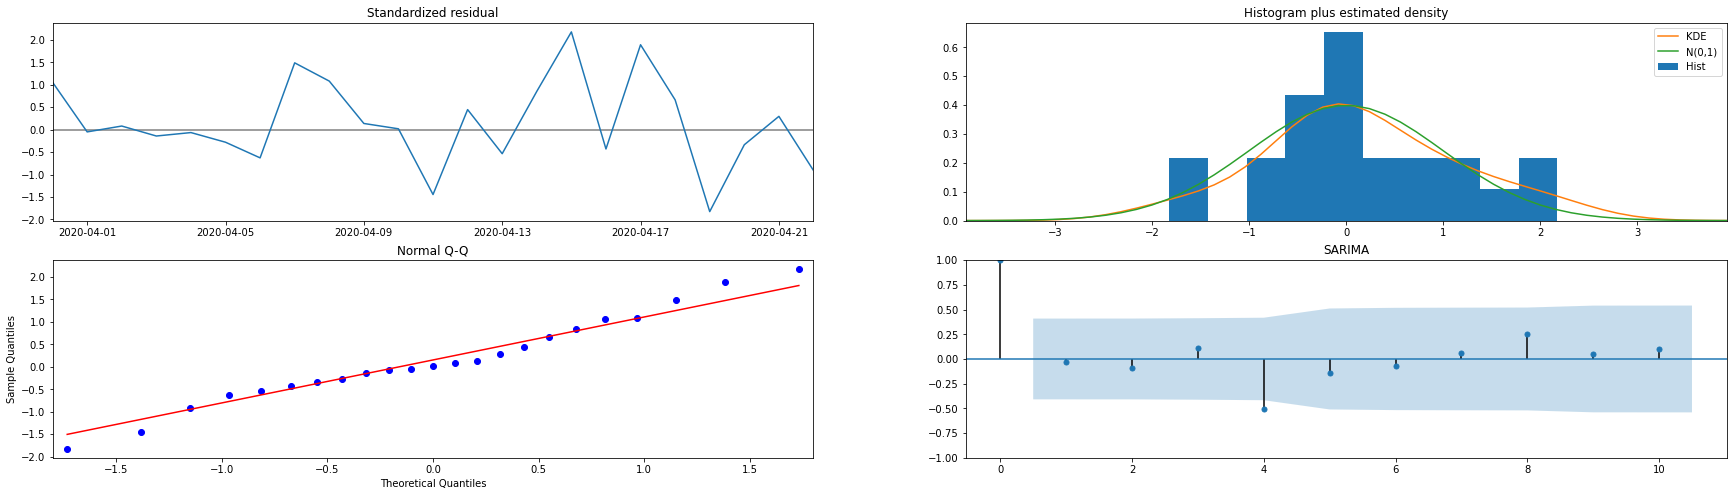

In [83]:
results.plot_diagnostics(figsize=(30, 8))
plt.title('SARIMA')
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

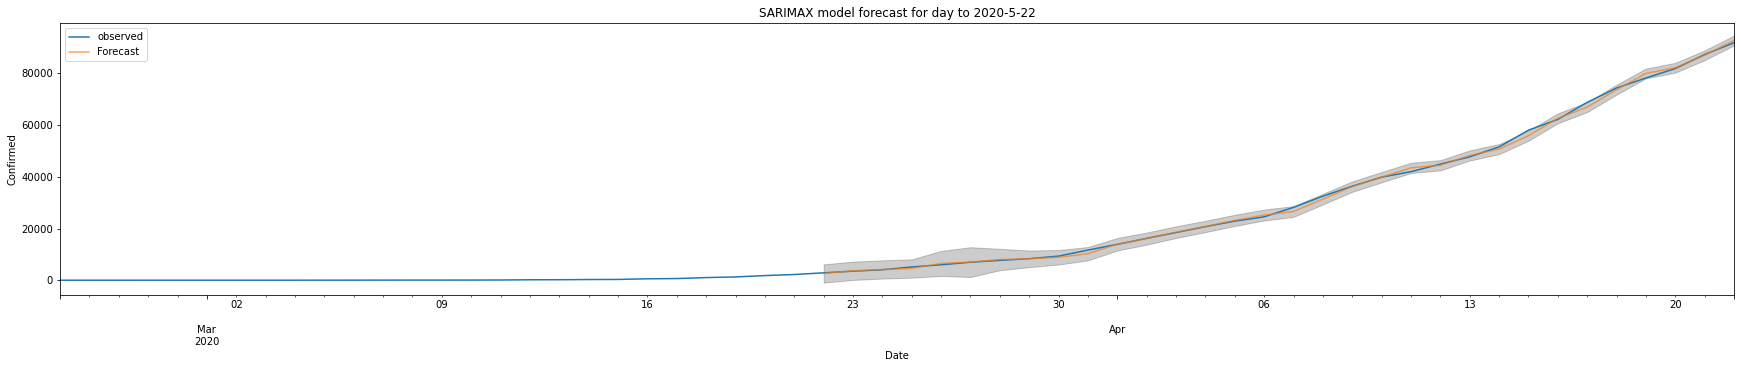

In [84]:
pred = results.get_prediction(start=pd.to_datetime(first), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=figsize)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel(campo)
plt.legend()
plt.title('SARIMAX model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)

In [85]:
y_forecasted = pred.predicted_mean
y_truth = y[first:]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error is {round(mse, 2)}')
print(f'The Root Mean Squared Error is {round(np.sqrt(mse), 2)}')

The Mean Squared Error is 735938.6
The Root Mean Squared Error is 857.87


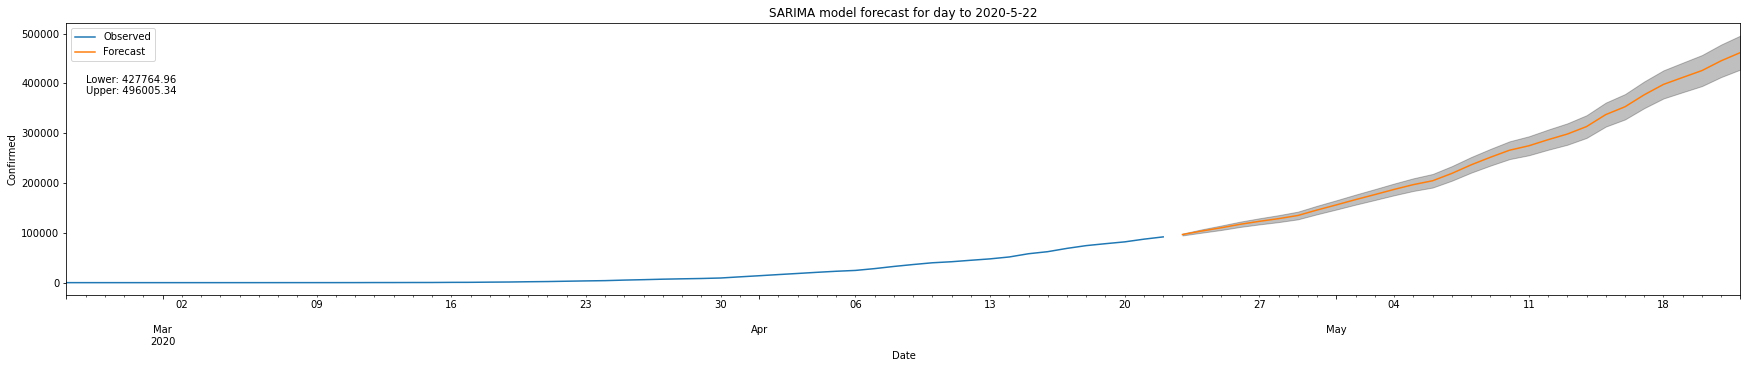

In [86]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='Observed', figsize=figsize)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(campo)
upper = round(pred_uc.conf_int()['upper Confirmed'].tail(1).values[0], 2)
lower = round(pred_uc.conf_int()['lower Confirmed'].tail(1).values[0], 2)
plt.text(x='2020-02-26', y=lower-50000, s=
    'Lower: ' + str(lower) +'\n'+
    'Upper: ' + str(upper)
)
plt.legend()
plt.title('SARIMA model forecast for day to ' + last)
if print_campo == 's':
    g += 1
    plt.savefig('ts\\0'+str(g)+'-'+campo+'_'+data+'.png', dpi=150)